#### Benchmaking Experiment 001
- Model : Model2
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
import math
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import *
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "glove50-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 15,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "dim_feedforward": 128,
    "num_layers": 2,
    "pos_encoding": 'fixed',
    "activation": 'relu',
    "norm": "BatchNorm",
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model11(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, num_layers, dim_feedforward, ft_size, attr_size,
                pos_encoding='fixed', activation='gelu', norm='BatchNorm', max_len=1024, dropout=0.1, freeze=False):
        super(Model11, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.attr_size = attr_size

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        self.pos_enc = get_pos_encoder(pos_encoding)(d_model, dropout=dropout*(1.0 - freeze), max_len=max_len)
        # relative global attention layer
        if norm == 'LayerNorm':
            encoder_layer = TransformerEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)
        else:
            encoder_layer = TransformerBatchNormEncoderLayer(d_model, self.num_heads, dim_feedforward, dropout*(1.0 - freeze), activation=activation)

        self.AttnL = nn.TransformerEncoder(encoder_layer, num_layers)

        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        # SAE submodule
        self.EncDenseL = nn.Linear(in_features=ft_size, out_features=attr_size, bias=False)
        self.DecDenseL = nn.Linear(in_features=attr_size, out_features=ft_size, bias=False)
        # override weights
        del self.EncDenseL.weight
        del self.DecDenseL.weight
        # define shared weights
        self.TransMet = nn.Parameter(torch.randn(attr_size, ft_size))

    def forward(self, x):
        x = x.permute(1,0,2)
        out = self.DenseL(x)
        out = self.pos_enc(out)* math.sqrt(self.d_model)
        out = self.AttnL(out)
        out = out.permute(1,0,2)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out = self.DenseL2(out)
        # SAE Operation
        self.EncDenseL.weight = self.TransMet
        self.DecDenseL.weight = self.TransMet.T 
        attr_out = self.EncDenseL(out)
        ft_out = self.DecDenseL(attr_out)
        return attr_out, ft_out

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [7]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [8]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 26/26 [00:00<00:00, 47.10batch/s, loss=5.92]


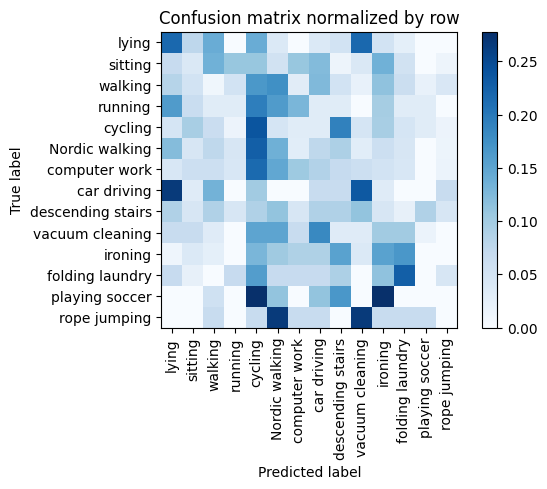

Training Epoch:  10%|█         | 1/10 [00:06<00:56,  6.23s/it]

Overall accuracy: 0.108



eval: 100%|██████████| 26/26 [00:00<00:00, 48.69batch/s, loss=1.87]


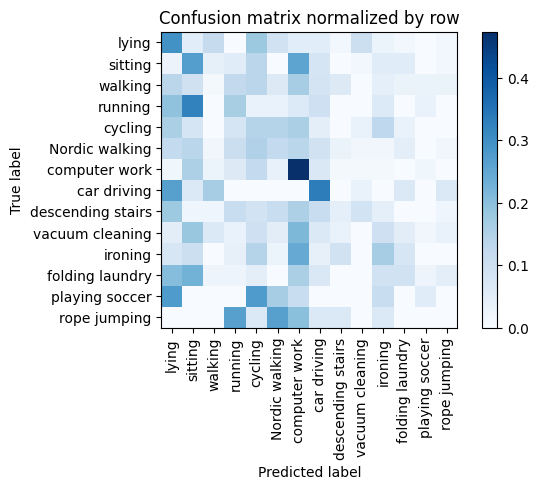

Training Epoch:  20%|██        | 2/10 [00:12<00:48,  6.05s/it]

Overall accuracy: 0.185



eval: 100%|██████████| 26/26 [00:00<00:00, 42.24batch/s, loss=1.08]


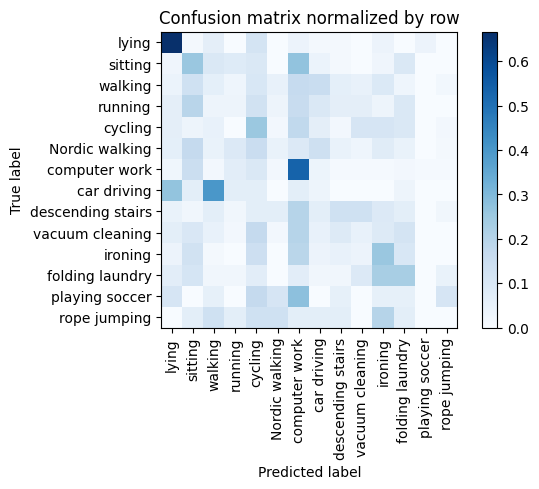

Training Epoch:  30%|███       | 3/10 [00:18<00:42,  6.08s/it]

Overall accuracy: 0.244



eval: 100%|██████████| 26/26 [00:00<00:00, 41.76batch/s, loss=0.928]


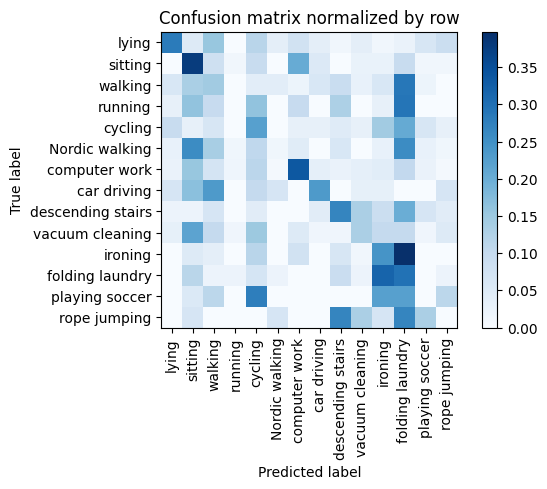

Training Epoch:  40%|████      | 4/10 [00:24<00:36,  6.14s/it]

Overall accuracy: 0.217



eval: 100%|██████████| 26/26 [00:00<00:00, 42.10batch/s, loss=0.69]


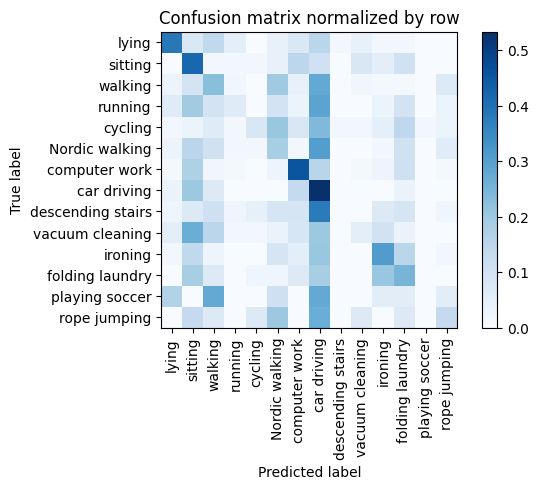

Training Epoch:  50%|█████     | 5/10 [00:30<00:30,  6.14s/it]

Overall accuracy: 0.259



eval: 100%|██████████| 26/26 [00:00<00:00, 45.65batch/s, loss=0.605]


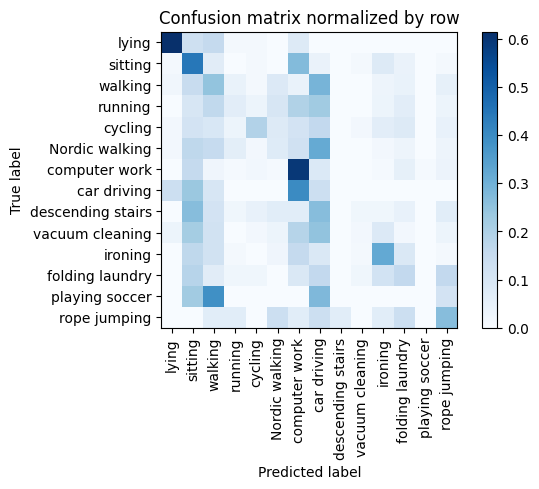

Training Epoch:  60%|██████    | 6/10 [00:36<00:24,  6.08s/it]

Overall accuracy: 0.287



eval: 100%|██████████| 26/26 [00:00<00:00, 39.78batch/s, loss=0.692]


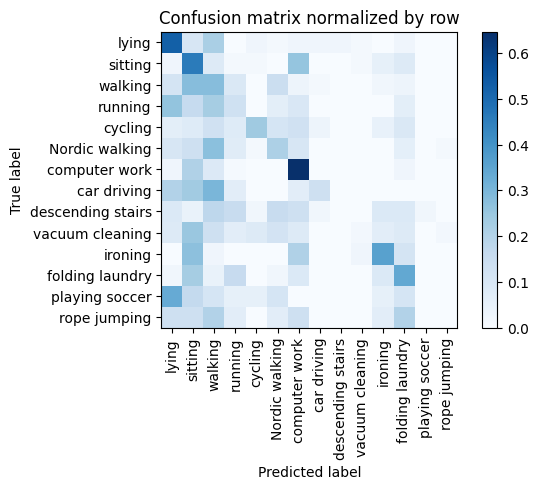

Training Epoch:  70%|███████   | 7/10 [00:43<00:18,  6.21s/it]

Overall accuracy: 0.317



eval: 100%|██████████| 26/26 [00:00<00:00, 42.34batch/s, loss=0.559]


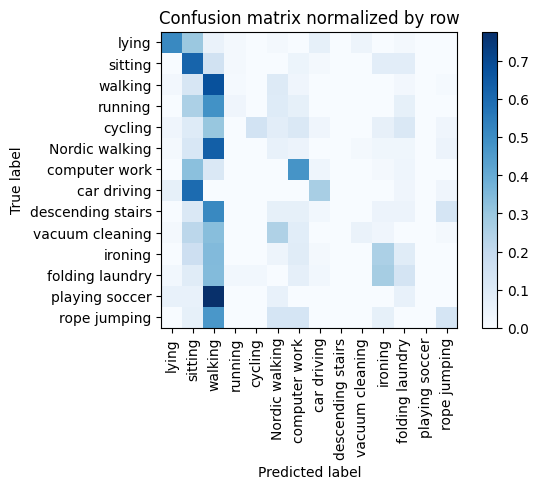

Training Epoch:  80%|████████  | 8/10 [00:49<00:12,  6.22s/it]

Overall accuracy: 0.319



eval: 100%|██████████| 26/26 [00:00<00:00, 44.67batch/s, loss=0.545]


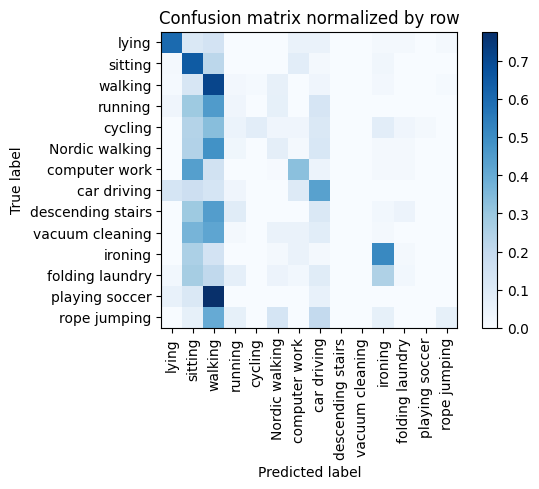

Training Epoch:  90%|█████████ | 9/10 [00:55<00:06,  6.31s/it]

Overall accuracy: 0.329



eval: 100%|██████████| 26/26 [00:00<00:00, 38.98batch/s, loss=0.58]


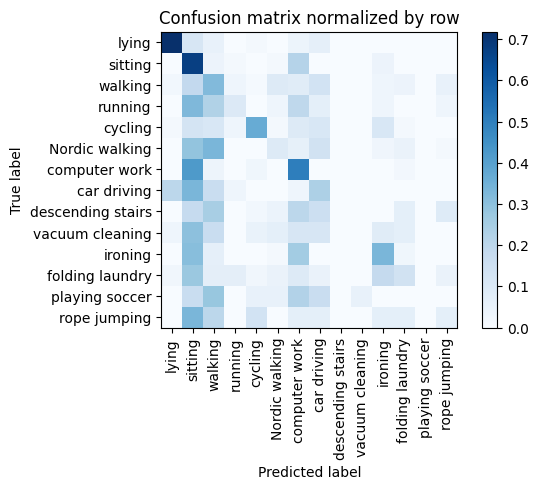

Overall accuracy: 0.328



eval: 100%|██████████| 28/28 [00:00<00:00, 53.74batch/s, loss=0.624]


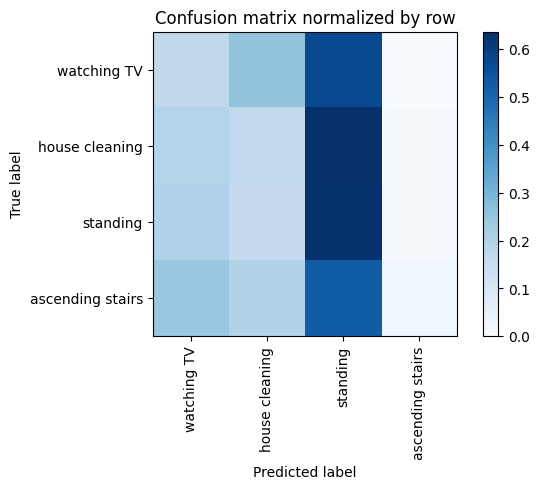

Overall accuracy: 0.288

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  house cleaning       0.304      0.167      0.215      0.336        294|	 standing: 0.636,	watching TV: 0.190,	
        standing       0.335      0.630      0.438      0.321        281|	 watching TV: 0.203,	house cleaning: 0.160,	
ascending stairs       0.556      0.028      0.053      0.204        179|	 standing: 0.525,	watching TV: 0.246,	house cleaning: 0.201,	
     watching TV       0.118      0.172      0.140      0.139        122|	 standing: 0.574,	house cleaning: 0.254,	

----------------------------------------------------------------------------------------------------
     avg / total       0.340      0.288      0.243        1.0        876|	      

{'total_accuracy': 0.2876712328767123, 'precision': 0.3282770456149181, 'recall': 0.2491560033839172, 'f1': 0.21153834015444095}
================ Fold-1 ================
Unseen Classes : ['walking', 'rope jumping', 

eval: 100%|██████████| 26/26 [00:00<00:00, 43.70batch/s, loss=5.58]


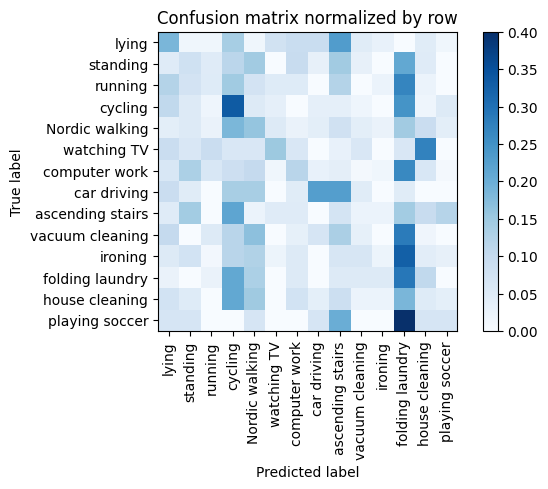

Training Epoch:  10%|█         | 1/10 [00:06<00:54,  6.09s/it]

Overall accuracy: 0.120



eval: 100%|██████████| 26/26 [00:00<00:00, 44.44batch/s, loss=2.16]


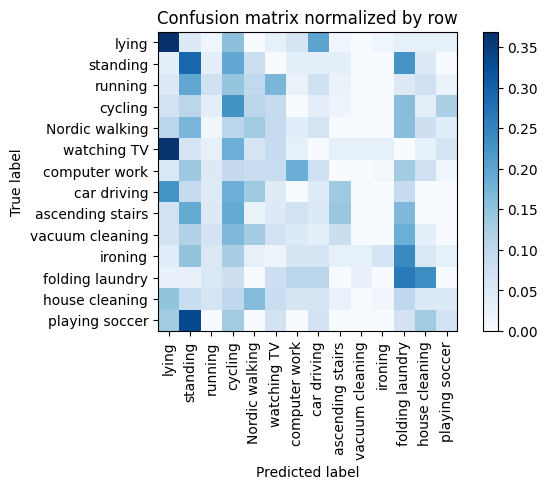

Training Epoch:  20%|██        | 2/10 [00:12<00:49,  6.19s/it]

Overall accuracy: 0.151



eval: 100%|██████████| 26/26 [00:00<00:00, 41.21batch/s, loss=1.2]


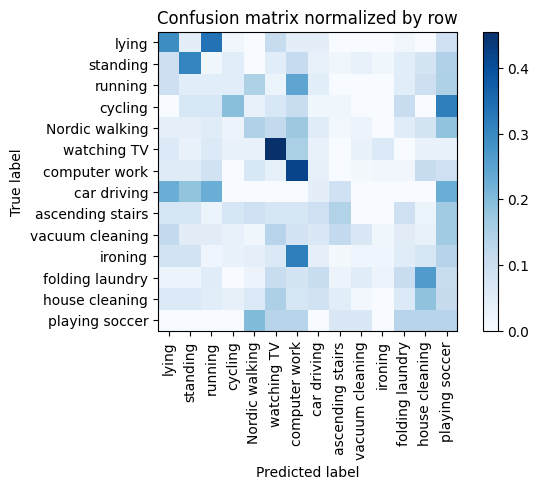

Training Epoch:  30%|███       | 3/10 [00:18<00:43,  6.22s/it]

Overall accuracy: 0.202



eval: 100%|██████████| 26/26 [00:00<00:00, 43.85batch/s, loss=1.16]


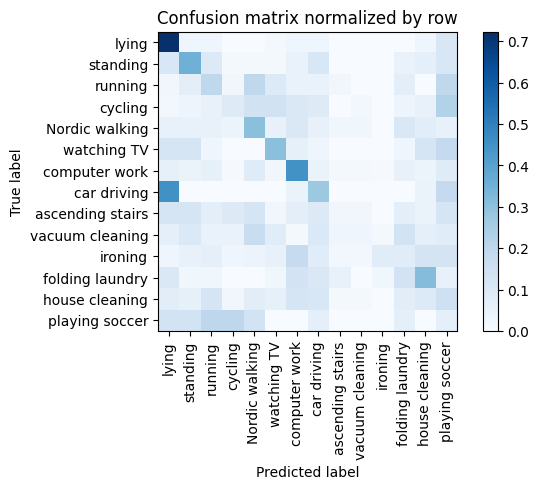

Training Epoch:  40%|████      | 4/10 [00:24<00:37,  6.24s/it]

Overall accuracy: 0.250



eval: 100%|██████████| 26/26 [00:00<00:00, 42.07batch/s, loss=0.828]


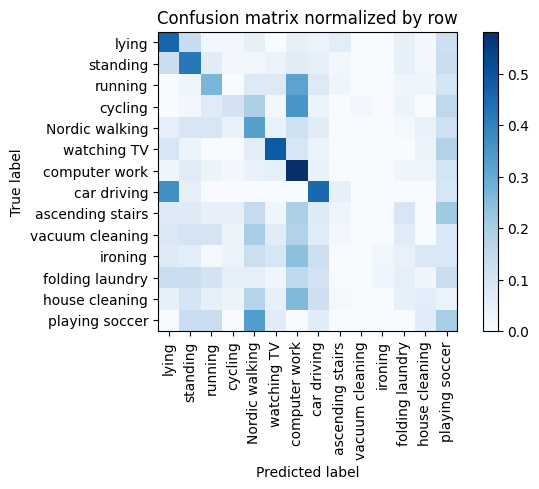

Training Epoch:  50%|█████     | 5/10 [00:31<00:31,  6.28s/it]

Overall accuracy: 0.260



eval: 100%|██████████| 26/26 [00:00<00:00, 41.67batch/s, loss=0.789]


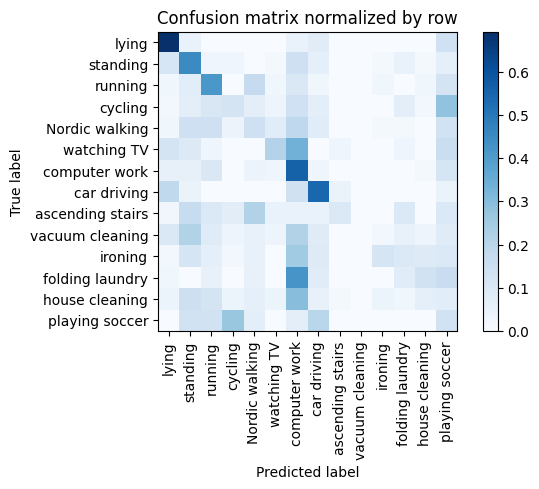

Training Epoch:  60%|██████    | 6/10 [00:37<00:25,  6.32s/it]

Overall accuracy: 0.275



eval: 100%|██████████| 26/26 [00:00<00:00, 36.08batch/s, loss=0.834]


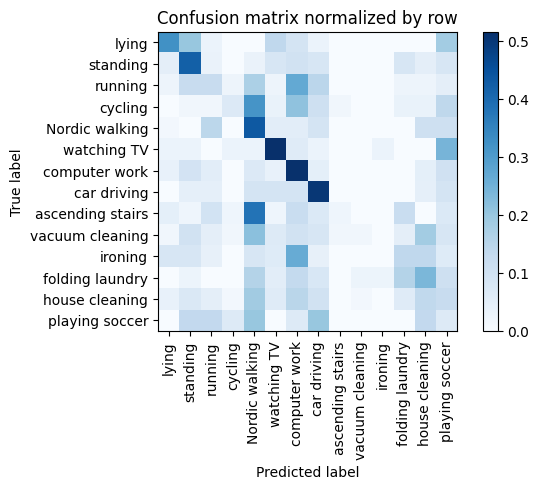

Training Epoch:  70%|███████   | 7/10 [00:43<00:18,  6.30s/it]

Overall accuracy: 0.249



eval: 100%|██████████| 26/26 [00:00<00:00, 45.86batch/s, loss=0.657]


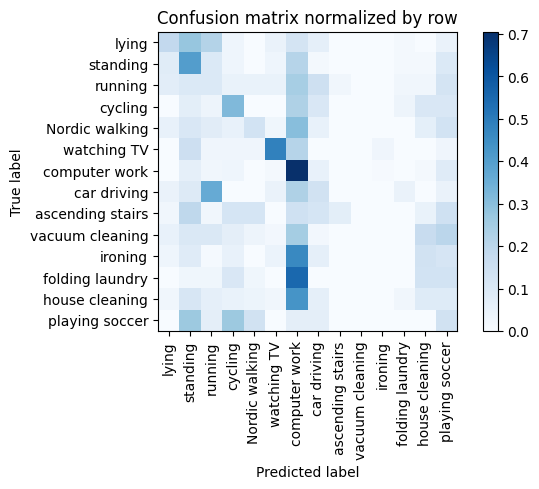

Training Epoch:  80%|████████  | 8/10 [00:50<00:12,  6.24s/it]

Overall accuracy: 0.234



eval: 100%|██████████| 26/26 [00:00<00:00, 41.67batch/s, loss=0.611]


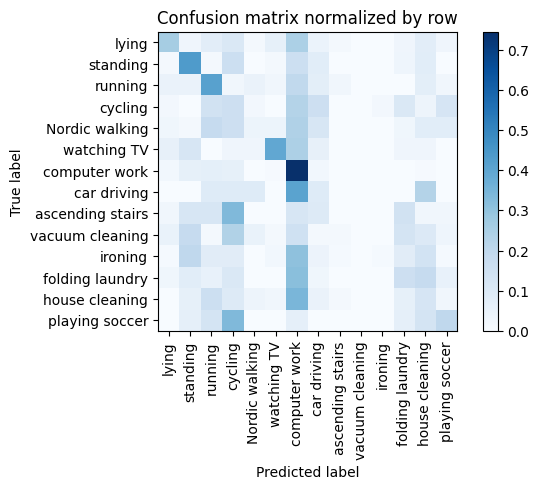

Training Epoch:  90%|█████████ | 9/10 [00:56<00:06,  6.31s/it]

Overall accuracy: 0.250



eval: 100%|██████████| 26/26 [00:00<00:00, 44.60batch/s, loss=0.681]


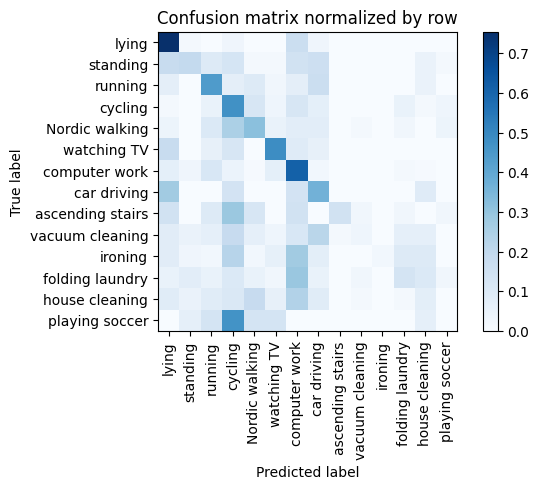

Overall accuracy: 0.311



eval: 100%|██████████| 28/28 [00:00<00:00, 44.30batch/s, loss=0.624]


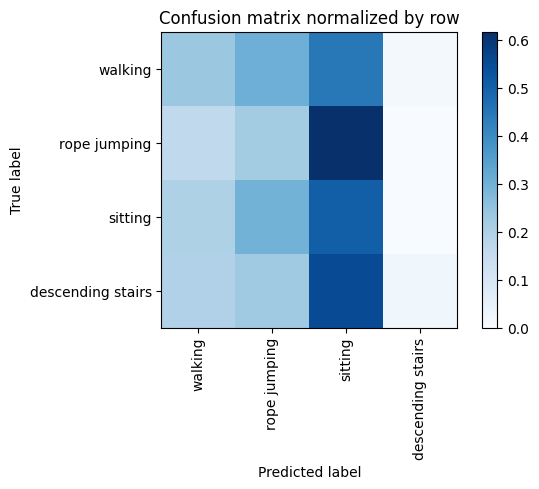

Overall accuracy: 0.279

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.462      0.235      0.312      0.414        361|	 sitting: 0.446,	rope jumping: 0.305,	
          sitting       0.322      0.505      0.393      0.317        277|	 rope jumping: 0.296,	walking: 0.199,	
descending stairs       0.444      0.024      0.045      0.191        167|	 sitting: 0.551,	rope jumping: 0.228,	walking: 0.198,	
     rope jumping       0.061      0.221      0.096      0.078         68|	 sitting: 0.618,	walking: 0.162,	

----------------------------------------------------------------------------------------------------
      avg / total       0.383      0.279      0.270        1.0        873|	      

{'total_accuracy': 0.27949599083619703, 'precision': 0.32236613410981585, 'recall': 0.24635313931732145, 'f1': 0.21162155582320918}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum clea

eval: 100%|██████████| 24/24 [00:00<00:00, 45.98batch/s, loss=5.74]


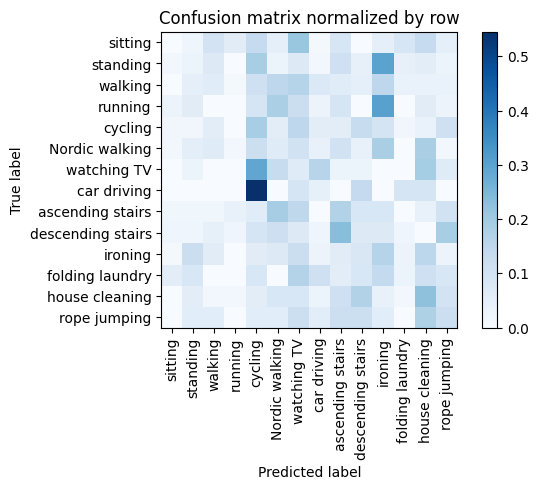

Training Epoch:  10%|█         | 1/10 [00:05<00:51,  5.75s/it]

Overall accuracy: 0.094



eval: 100%|██████████| 24/24 [00:00<00:00, 42.55batch/s, loss=2.5]


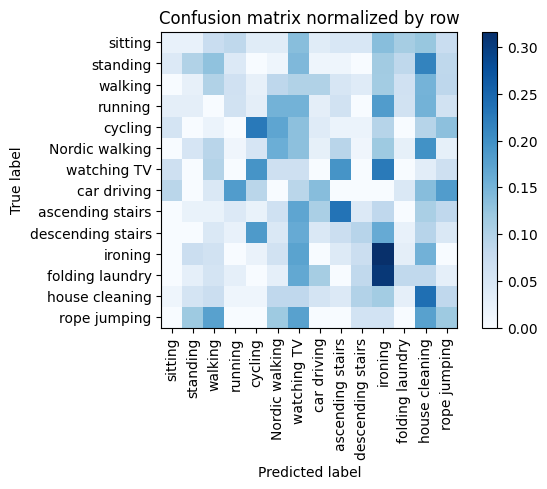

Training Epoch:  20%|██        | 2/10 [00:11<00:45,  5.72s/it]

Overall accuracy: 0.153



eval: 100%|██████████| 24/24 [00:00<00:00, 45.03batch/s, loss=1.79]


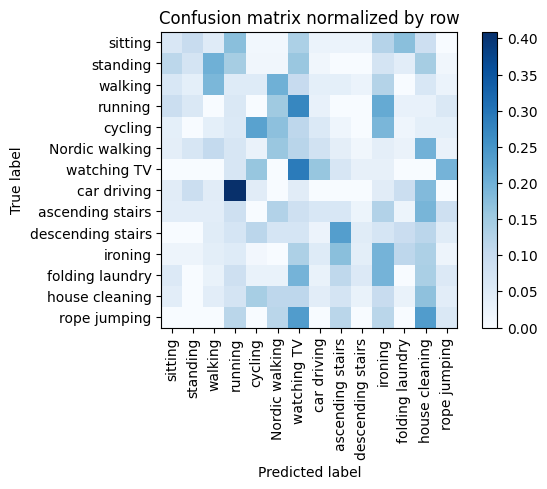

Training Epoch:  30%|███       | 3/10 [00:16<00:39,  5.62s/it]

Overall accuracy: 0.128



eval: 100%|██████████| 24/24 [00:00<00:00, 44.36batch/s, loss=1.23]


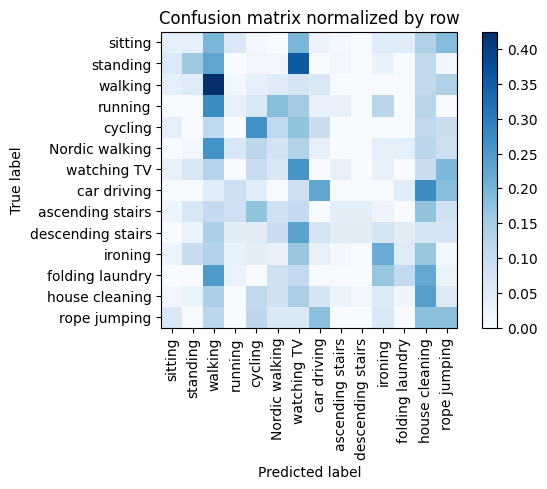

Training Epoch:  40%|████      | 4/10 [00:22<00:34,  5.73s/it]

Overall accuracy: 0.173



eval: 100%|██████████| 24/24 [00:00<00:00, 40.07batch/s, loss=0.949]


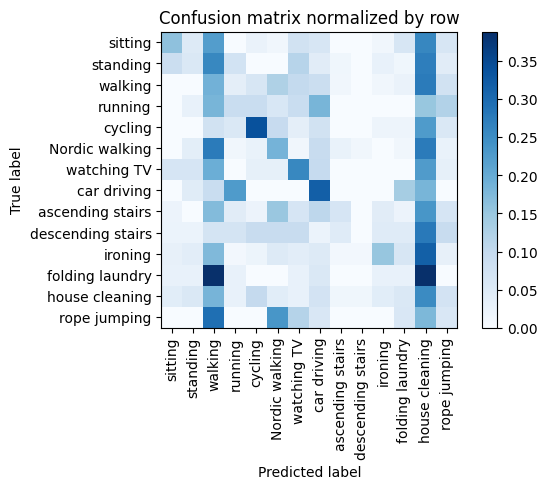

Training Epoch:  50%|█████     | 5/10 [00:28<00:28,  5.66s/it]

Overall accuracy: 0.158



eval: 100%|██████████| 24/24 [00:00<00:00, 53.57batch/s, loss=0.765]


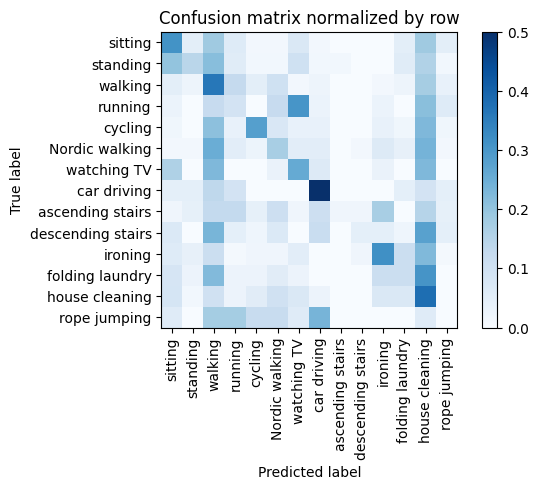

Training Epoch:  60%|██████    | 6/10 [00:33<00:22,  5.56s/it]

Overall accuracy: 0.236



eval: 100%|██████████| 24/24 [00:00<00:00, 41.96batch/s, loss=0.775]


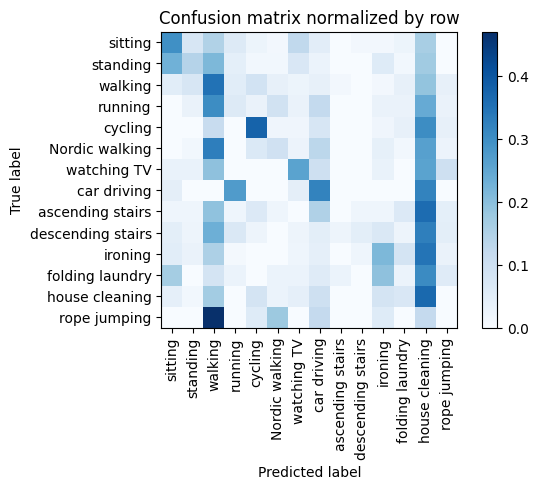

Training Epoch:  70%|███████   | 7/10 [00:39<00:16,  5.50s/it]

Overall accuracy: 0.206



eval: 100%|██████████| 24/24 [00:00<00:00, 44.28batch/s, loss=0.675]


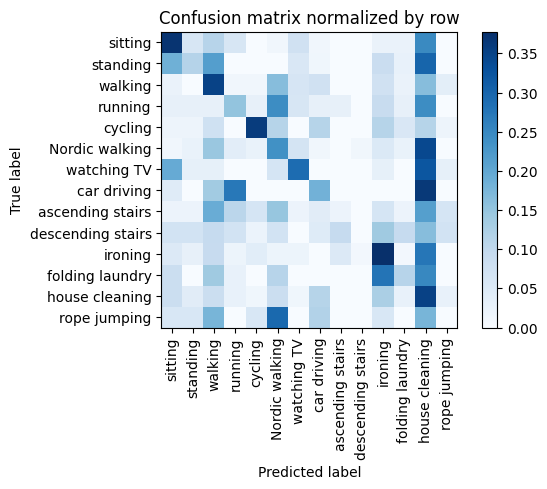

Training Epoch:  80%|████████  | 8/10 [00:44<00:11,  5.55s/it]

Overall accuracy: 0.248



eval: 100%|██████████| 24/24 [00:00<00:00, 46.24batch/s, loss=0.698]


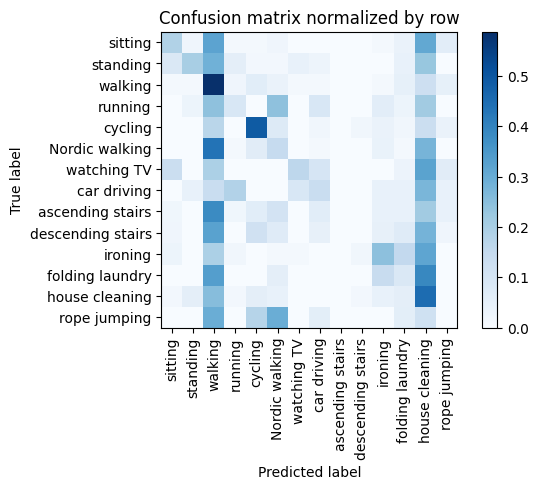

Training Epoch:  90%|█████████ | 9/10 [00:50<00:05,  5.54s/it]

Overall accuracy: 0.241



eval: 100%|██████████| 24/24 [00:00<00:00, 45.80batch/s, loss=0.636]


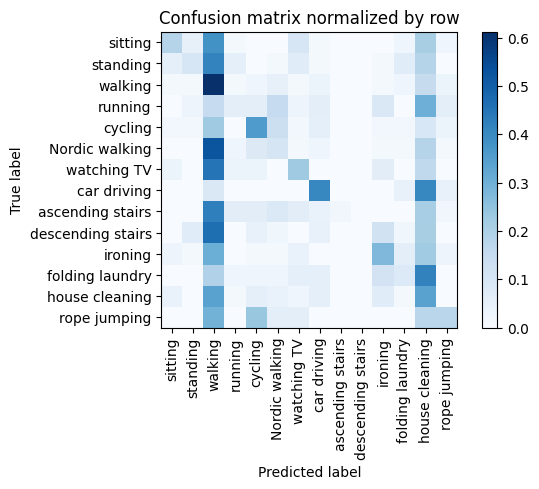

Overall accuracy: 0.230



eval: 100%|██████████| 35/35 [00:00<00:00, 43.97batch/s, loss=0.676]


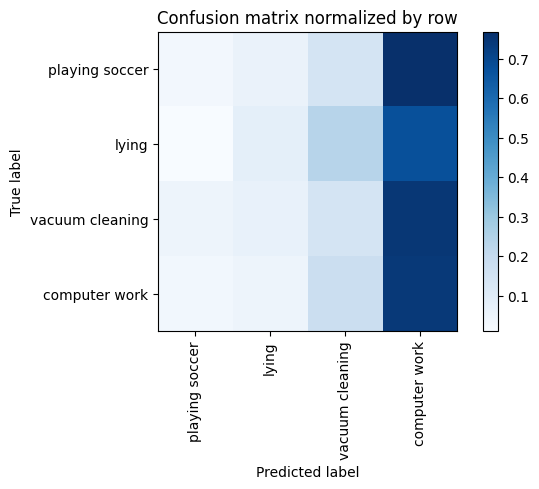

Overall accuracy: 0.376

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.438      0.741      0.551      0.430        475|	 vacuum cleaning: 0.179,	lying: 0.048,	
          lying       0.338      0.080      0.130      0.259        286|	 computer work: 0.675,	vacuum cleaning: 0.234,	
vacuum cleaning       0.194      0.142      0.164      0.249        275|	 computer work: 0.745,	lying: 0.065,	
 playing soccer       0.061      0.029      0.039      0.062         69|	 computer work: 0.768,	vacuum cleaning: 0.145,	lying: 0.058,	

----------------------------------------------------------------------------------------------------
    avg / total       0.328      0.376      0.314        1.0       1105|	      

{'total_accuracy': 0.3764705882352941, 'precision': 0.2578068424633845, 'recall': 0.2480689752657716, 'f1': 0.22097136379816507}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic wal

eval: 100%|██████████| 27/27 [00:00<00:00, 40.06batch/s, loss=4.79]


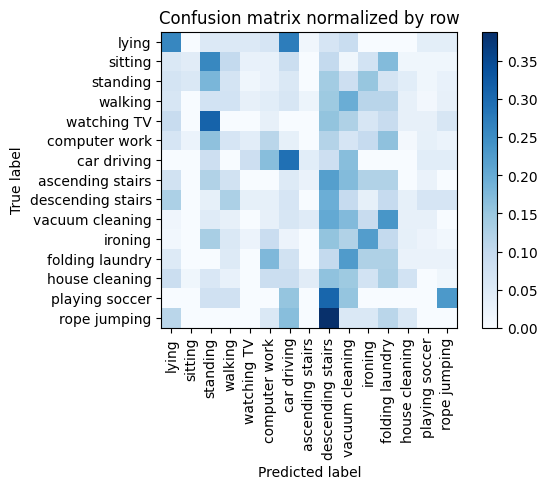

Training Epoch:  10%|█         | 1/10 [00:06<00:55,  6.13s/it]

Overall accuracy: 0.130



eval: 100%|██████████| 27/27 [00:00<00:00, 42.86batch/s, loss=1.87]


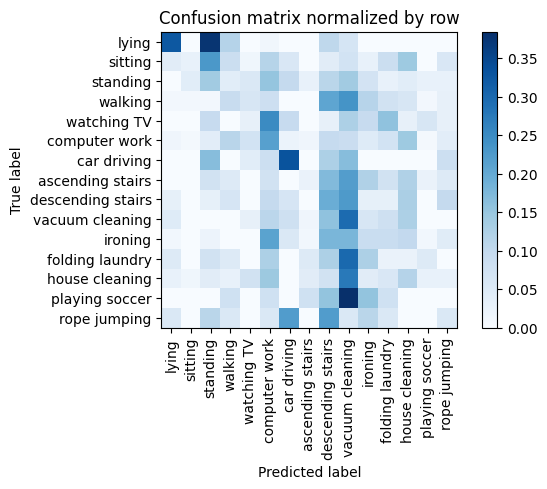

Training Epoch:  20%|██        | 2/10 [00:12<00:49,  6.18s/it]

Overall accuracy: 0.146



eval: 100%|██████████| 27/27 [00:00<00:00, 47.45batch/s, loss=1.17]


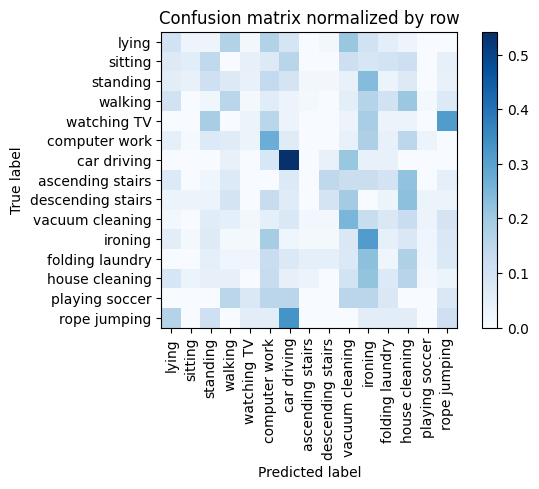

Training Epoch:  30%|███       | 3/10 [00:19<00:45,  6.48s/it]

Overall accuracy: 0.167



eval: 100%|██████████| 27/27 [00:00<00:00, 38.74batch/s, loss=0.916]


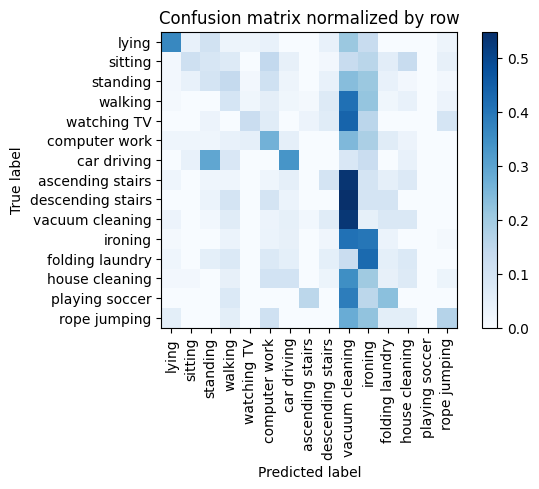

Training Epoch:  40%|████      | 4/10 [00:25<00:39,  6.51s/it]

Overall accuracy: 0.205



eval: 100%|██████████| 27/27 [00:00<00:00, 36.14batch/s, loss=0.765]


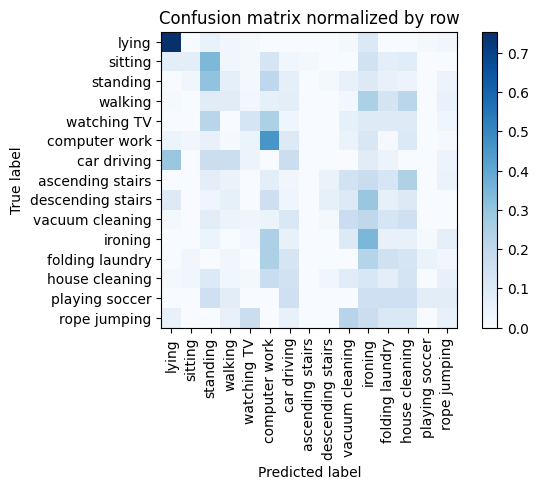

Training Epoch:  50%|█████     | 5/10 [00:32<00:32,  6.55s/it]

Overall accuracy: 0.254



eval: 100%|██████████| 27/27 [00:00<00:00, 41.16batch/s, loss=0.776]


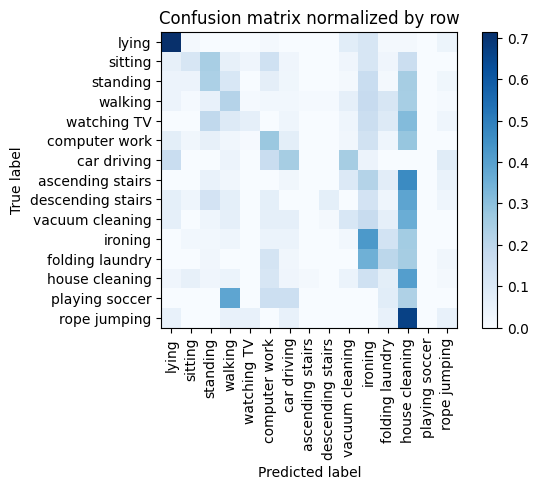

Training Epoch:  60%|██████    | 6/10 [00:38<00:26,  6.58s/it]

Overall accuracy: 0.263



eval: 100%|██████████| 27/27 [00:00<00:00, 46.31batch/s, loss=0.622]


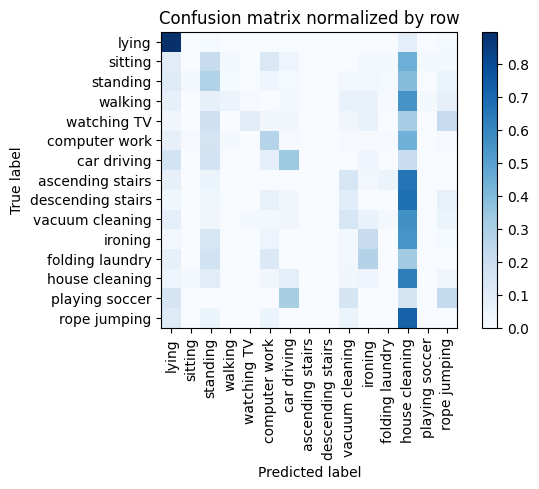

Training Epoch:  70%|███████   | 7/10 [00:45<00:19,  6.51s/it]

Overall accuracy: 0.243



eval: 100%|██████████| 27/27 [00:00<00:00, 45.30batch/s, loss=0.61]


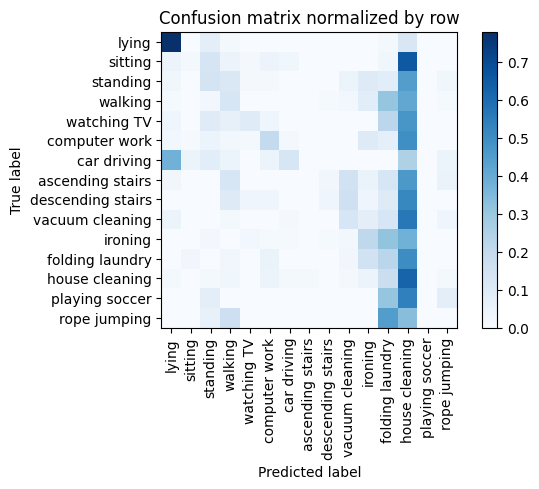

Training Epoch:  80%|████████  | 8/10 [00:51<00:12,  6.46s/it]

Overall accuracy: 0.225



eval: 100%|██████████| 27/27 [00:00<00:00, 45.92batch/s, loss=0.585]


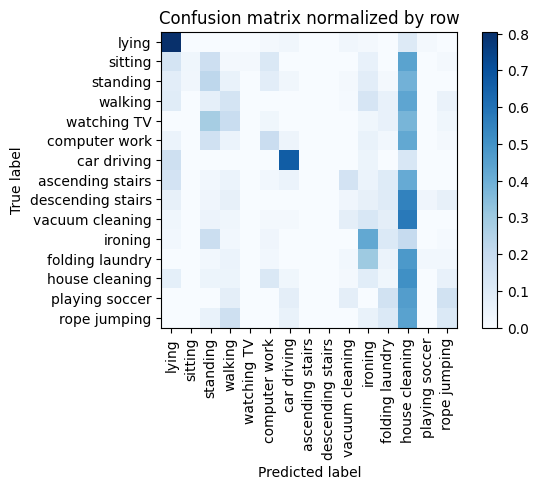

Training Epoch:  90%|█████████ | 9/10 [00:57<00:06,  6.36s/it]

Overall accuracy: 0.249



eval: 100%|██████████| 27/27 [00:00<00:00, 46.71batch/s, loss=0.611]


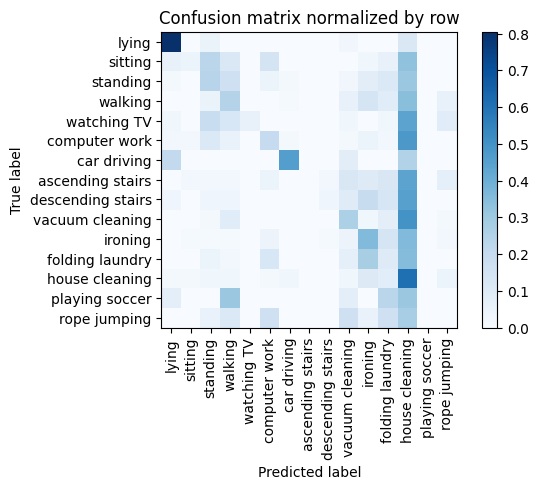

Overall accuracy: 0.278



eval: 100%|██████████| 22/22 [00:00<00:00, 43.22batch/s, loss=0.749]


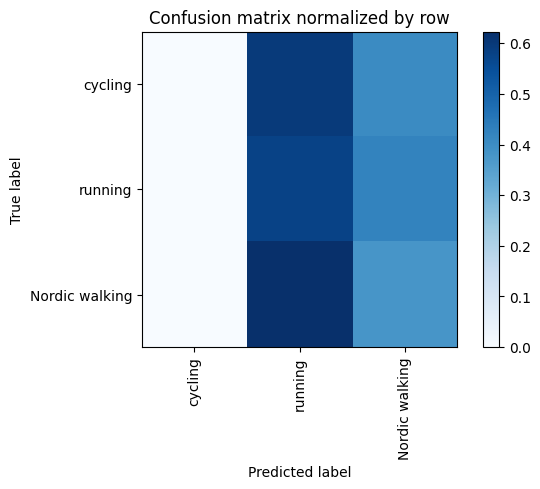

Overall accuracy: 0.280

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.390      0.377      0.383      0.410        281|	 running: 0.623,	cycling: 0.000,	
       cycling       0.000      0.000      0.000      0.372        255|	 running: 0.596,	Nordic walking: 0.404,	
       running       0.208      0.577      0.306      0.218        149|	 Nordic walking: 0.423,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.205      0.280      0.224        1.0        685|	      

{'total_accuracy': 0.28029197080291973, 'precision': 0.19931277595784078, 'recall': 0.31813513578064917, 'f1': 0.22980443134504128}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 28/28 [00:00<00:00, 45.31batch/s, loss=4.23]


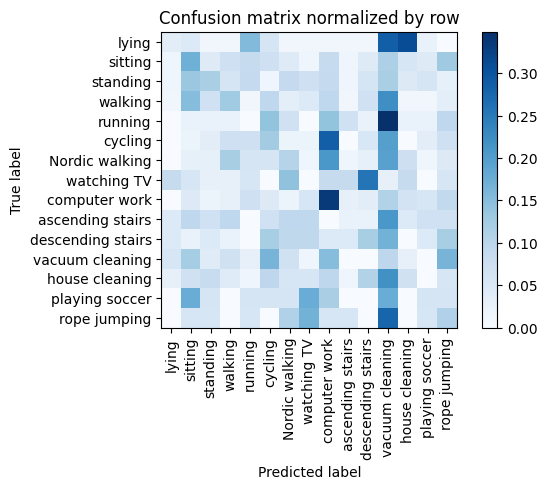

Training Epoch:  10%|█         | 1/10 [00:06<00:58,  6.49s/it]

Overall accuracy: 0.120



eval: 100%|██████████| 28/28 [00:00<00:00, 43.01batch/s, loss=2.16]


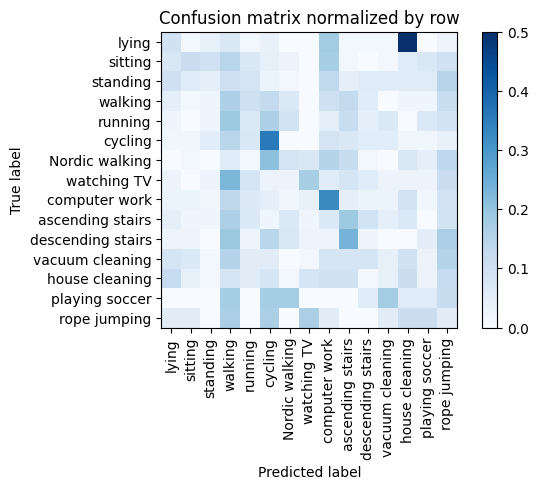

Training Epoch:  20%|██        | 2/10 [00:13<00:52,  6.58s/it]

Overall accuracy: 0.142



eval: 100%|██████████| 28/28 [00:00<00:00, 45.90batch/s, loss=1.11]


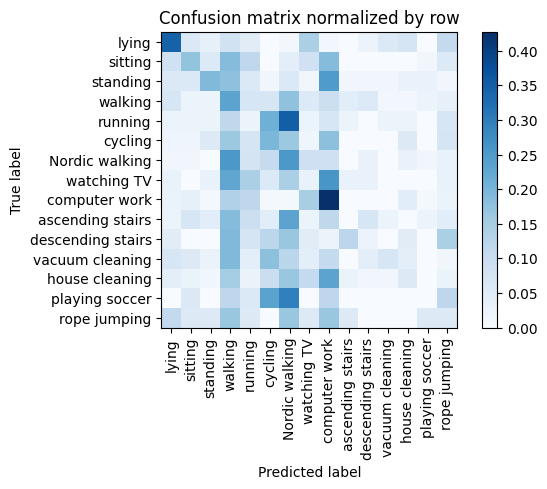

Training Epoch:  30%|███       | 3/10 [00:19<00:45,  6.50s/it]

Overall accuracy: 0.183



eval: 100%|██████████| 28/28 [00:00<00:00, 42.68batch/s, loss=1.02]


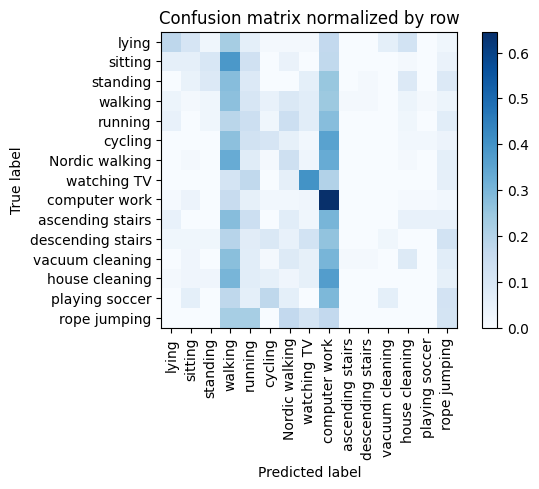

Training Epoch:  40%|████      | 4/10 [00:26<00:39,  6.56s/it]

Overall accuracy: 0.176



eval: 100%|██████████| 28/28 [00:00<00:00, 57.14batch/s, loss=0.915]


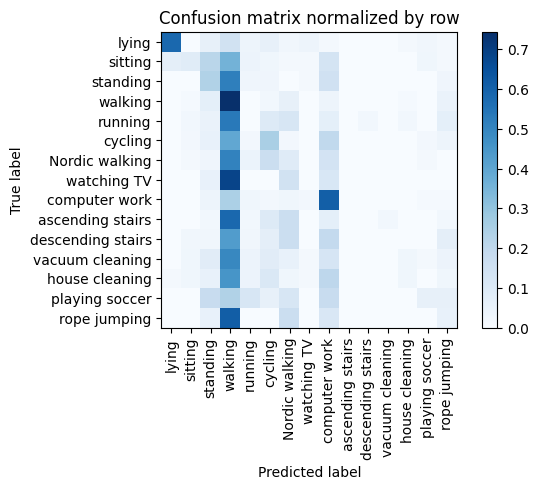

Training Epoch:  50%|█████     | 5/10 [00:31<00:31,  6.26s/it]

Overall accuracy: 0.255



eval: 100%|██████████| 28/28 [00:00<00:00, 53.23batch/s, loss=0.735]


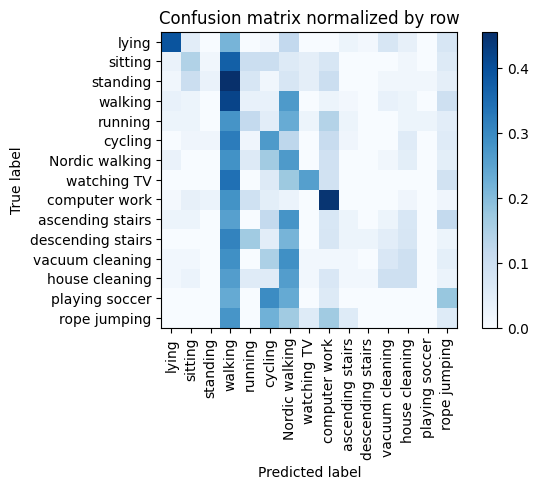

Training Epoch:  60%|██████    | 6/10 [00:36<00:22,  5.61s/it]

Overall accuracy: 0.217



eval: 100%|██████████| 28/28 [00:00<00:00, 57.97batch/s, loss=0.697]


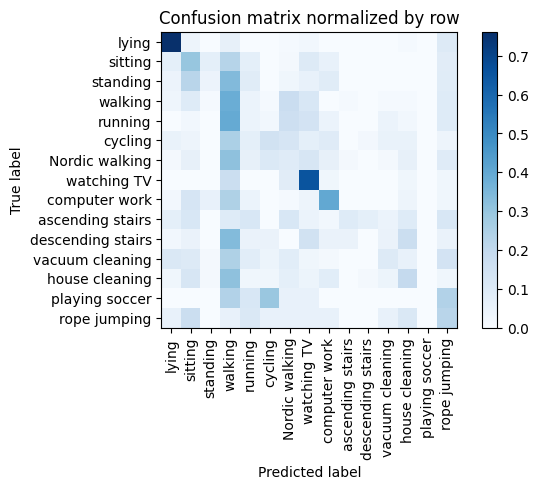

Training Epoch:  70%|███████   | 7/10 [00:40<00:15,  5.13s/it]

Overall accuracy: 0.263



eval: 100%|██████████| 28/28 [00:00<00:00, 59.45batch/s, loss=0.671]


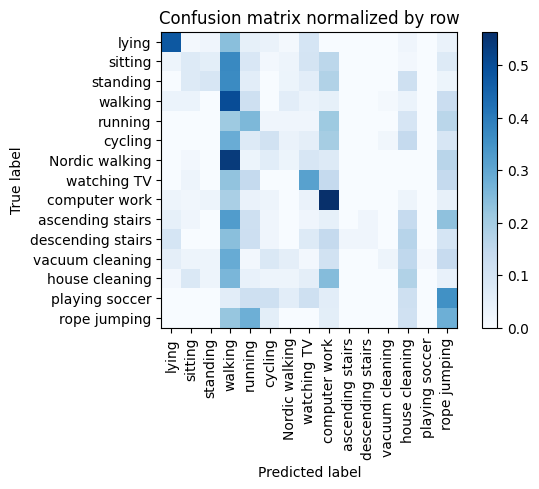

Training Epoch:  80%|████████  | 8/10 [00:44<00:09,  4.78s/it]

Overall accuracy: 0.234



eval: 100%|██████████| 28/28 [00:00<00:00, 57.73batch/s, loss=0.646]


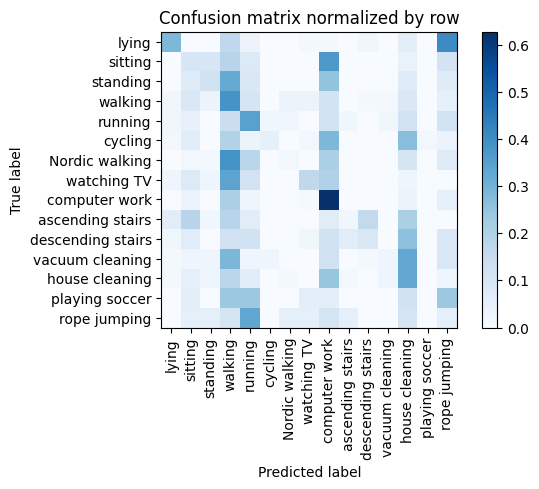

Training Epoch:  90%|█████████ | 9/10 [00:48<00:04,  4.56s/it]

Overall accuracy: 0.224



eval: 100%|██████████| 28/28 [00:00<00:00, 58.58batch/s, loss=0.611]


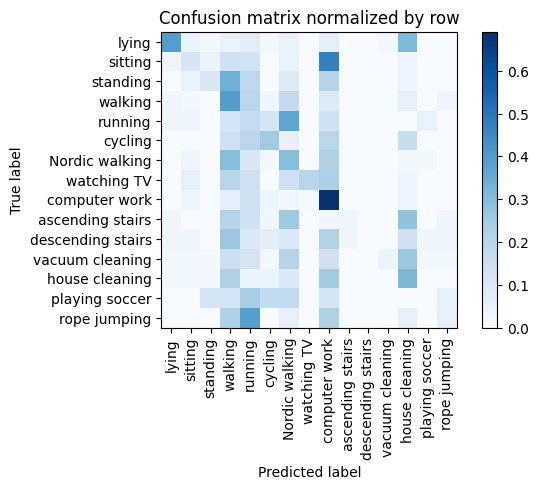

Overall accuracy: 0.264



eval: 100%|██████████| 19/19 [00:00<00:00, 50.26batch/s, loss=0.721]


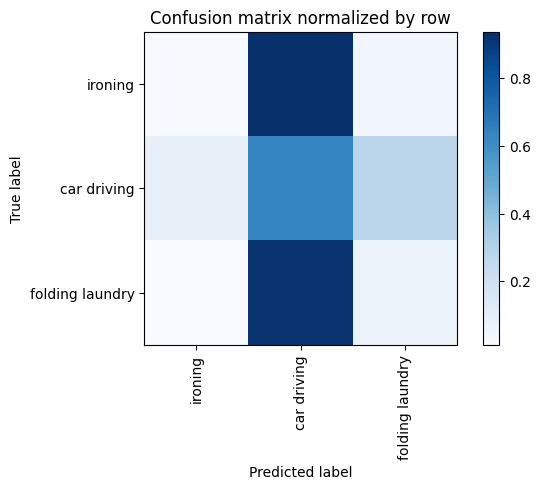

Overall accuracy: 0.125

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.412      0.020      0.038      0.586        351|	 car driving: 0.937,	folding laundry: 0.043,	
folding laundry       0.200      0.064      0.097      0.262        157|	 car driving: 0.924,	ironing: 0.013,	
    car driving       0.109      0.637      0.186      0.152         91|	 folding laundry: 0.275,	ironing: 0.088,	

----------------------------------------------------------------------------------------------------
    avg / total       0.310      0.125      0.076        1.0        599|	      

{'total_accuracy': 0.12520868113522537, 'precision': 0.24026242075777682, 'recall': 0.24033330827386026, 'f1': 0.10695255413135236}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.269828
precision         0.269605
recall            0.260409
f1                0.196178
dtype: float64

In [10]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model11(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], dim_feedforward=config['dim_feedforward'], 
                num_layers=config['num_layers'], ft_size=feat_size, attr_size=attr_size, max_len=seq_len, pos_encoding=config['pos_encoding'], activation=config['activation'], norm=config['norm'])
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=True)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=True, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=True)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    